# Imports

In [1]:
import numpy as np
from scipy import stats
import random

import matplotlib.pyplot as plt
%matplotlib inline

# import library
%run lib.ipynb

# Generate data (yulesimon)

In [2]:
from scipy.stats import yulesimon

def sample_yulesimon(alpha, size):
    return yulesimon.rvs(alpha, loc=0, size=size)

def next_alpha(min_alpha=2.0, max_alpha=3.0):
    alpha = np.random.uniform(low=min_alpha, high=max_alpha, size=1)[0]
    return alpha

# generate data
NUM_DATA_POINTS = 256
H, alpha = generate_data(N=10000, M=NUM_DATA_POINTS, nextConfig=next_alpha, sample=sample_yulesimon)

# split train/test
# (use train_test_split so the shape of the train/test data will be the same)
H_train, H_test, y_train, y_test = train_test_split(H, alpha, test_size=0.25)
print(f'H_train.shape: {H_train.shape}')
print(f'H_test.shape: {H_test.shape}')

# log scale histogram rows
# (shift H values by one so as not to take log of zero)
log_H_train = np.apply_along_axis(lambda a: np.log10(a), 1, H_train + 1)
log_H_test = np.apply_along_axis(lambda a: np.log10(a), 1, H_test + 1)

H_train.shape: (7500, 5367)
H_test.shape: (2500, 5367)


# Plot histogram and log scale of a single row

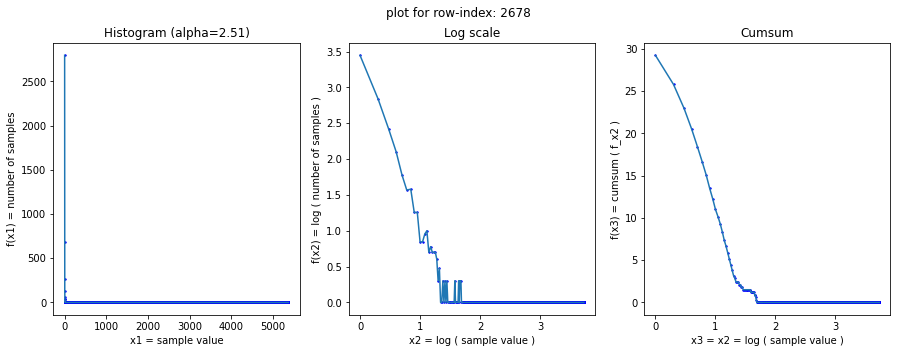

In [3]:
# plot random row
ROW_INDEX_TO_PLOT = random.randint(0, H_train.shape[0] - 1)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.suptitle(f'plot for row-index: {ROW_INDEX_TO_PLOT}')

# plot histogram
f_x1 = H_train[ROW_INDEX_TO_PLOT,:]
x1 = np.array(range(len(f_x1)))
plt.subplot(1, 3, 1)
plt.title('Histogram (alpha={:.2f})'.format(y_train[0]))
plt.xlabel('x1 = sample value')
plt.ylabel('f(x1) = number of samples')
_ = plt.plot(x1, f_x1, zorder=2)
_ = plt.scatter(x1, f_x1, zorder=1, s=2, color="blue")

# plot log scale
x2 = np.log10(x1+1)
f_x2 = log_H_train[ROW_INDEX_TO_PLOT,:]
plt.subplot(1, 3, 2)
plt.title('Log scale')
plt.xlabel('x2 = log ( sample value )')
plt.ylabel('f(x2) = log ( number of samples )')
_ = plt.plot(x2, f_x2, zorder=2)
_ = plt.scatter(x2, f_x2, zorder=1, s=2, color="blue")

# plot cumsum
x3 = x2
f_x3 = np.cumsum(f_x2[::-1])[::-1]
plt.subplot(1, 3, 3)
plt.title('Cumsum')
plt.xlabel('x3 = x2 = log ( sample value )')
plt.ylabel('f(x3) = cumsum ( f_x2 )')
_ = plt.plot(x3, f_x3, zorder=2)
_ = plt.scatter(x3, f_x3, zorder=1, s=2, color="blue")


# Create and train DNN model

In [4]:
def dnn_trial(X_train, y_train, X_test, y_test):
    dnn_model = create_dnn_model(X_train.shape[1], 
                            layers=[256,256], 
                            activation='relu', 
                            init=keras.initializers.HeUniform(), 
                            batch_normalization=True, 
                            dropout=0.0, 
                            optimizer=Adam(learning_rate=1e-2), 
                            k_reg=True,
                            k_reg_lr=1e-5, 
                            a_reg=True,
                            a_reg_lr=1e-5)

    # train
    dnn_model, history = train_model(dnn_model, X_train, y_train)

    # plot learning curves
    plot_learning_curves(history)

    # predict
    y_pred = dnn_model.predict(X_test).flatten()

    # mse
    mse = mean_squared_error(y_test, y_pred)

    # sqrt_mse
    sqrt_mse = np.sqrt(mse)

    print(f'sqrt_mse: {sqrt_mse:.3f}')

# Trials: train on H vs. on logH

Runing for M in [256, 512, 1024, 2048, 4096]  
For each M run with density=True/False  
Measure execution time  

We can see that:  
1. MSE decreases for larger M
2. Training time on logM is silightly better then training on M

| M    | train | sqrt_mse | time | density | m    |
| ---  | ---   | ---      | ---  | ---     | ---  |
|  256 | H     | 0.209    | 1m   | True    | 2243 |
|  256 | logH  | 0.198    | 1m   | True    | 2243 |
|  256 | H     | 0.209    | 1m   | False   | 1577 |
|  256 | logH  | 0.205    | 30s  | False   | 1577 |
|  512 | H     | 0.168    | 60s  | True    | 3530 |
|  512 | logH  | 0.162    | 2m   | True    | 3530 |
|  512 | H     | 0.163    | 50s  | False   |  880 |
|  512 | logH  | 0.174    | 20s  | False   |  880 |
| 1024 | H     | 0.114    | 2-4m | True    | 2700 |
| 1024 | logH  | 0.114    | 1-3m | True    | 2700 |
| 1024 | H     | 0.124    | 38s  | False   | 1500 |
| 1024 | logH  | 0.141    | 29s  | False   | 1500 |
| 2048 | H     | 0.101    | 53s  | True    | 2306 |
| 2048 | logH  | 0.089    | 1m   | True    | 2306 |
| 2048 | H     | 0.091    | 2m   | False   | 2674 |
| 2048 | logH  | 0.102    | 45s  | False   | 2674 |
| 4096 | H     | 0.071    | 2.5m | True    | 7467 |
| 4096 | logH  | 0.066    | 3m   | True    | 7467 |
| 4096 | H     | 0.068    | 3.5m | False   | 5367 |
| 4096 | logH  | 0.083    | 2m   | False   | 5367 |


## Train directly on H

M = 4096
loss: 0.00807134
val_loss: 0.00631875
sqrt_mse: 0.068
CPU times: user 19min 44s, sys: 49.1 s, total: 20min 33s
Wall time: 3min 41s


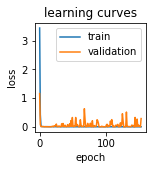

In [5]:
%%time
print(f'M = {NUM_DATA_POINTS}')
dnn_trial(X_train=H_train, y_train=y_train, X_test=H_test, y_test=y_test)

## Train on log(H)

loss: 0.00678379
val_loss: 0.00890715
sqrt_mse: 0.083
CPU times: user 11min 26s, sys: 26.5 s, total: 11min 52s
Wall time: 2min 9s


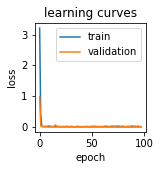

In [6]:
%%time
dnn_trial(X_train=log_H_train, y_train=y_train, X_test=log_H_test, y_test=y_test)